# 1D Projection Schemes

There are three 1D algorithms in Chapter 5.  Here are fixed iteration count version in Julia

In [5]:
using LinearAlgebra, SparseArrays
#Steepest Descent Step from Alg 5.2 p138
#Assumption A is SPD
function SteepDes(A,x,p,r)
    alpha = dot(r,r)/dot(p,r)
    x=x+alpha*r
    r=r-alpha*p
    p=A*r
end

#Minimum Residual Step from Alg 5.3 p140
#Assumption A+A' is SPD
function MinRes(A,x,p,r)
    alpha = dot(p,r)/dot(p,p)
    x=x+alpha*r
    r=r-alpha*p
    p=A*r
end

#Residual Norm Step from Alg 5.4 p142
#Assumption A'A is non-singular
function ResNorm(A,x,r)
    v=A'*r
    Av=A*v
    alpha = dot(v,v)/dot(Av,Av)
    x=x+alpha*v
    r=r-alpha*Av
end
;

# Assumptions
The assumptiions are real:

- Just because an algorithm runs does not mean it is converging! 
- Algorithms will (almost certainly) fail to converge on matrices that fail to satisfy the assumptions.
- SD has the most stringent assuptions followed by MR followed by RN.
- The assumptions for RN are *almost* non existent.

# Comparison
As a test I am going to run all three on a randomly generated SPD matrix. 

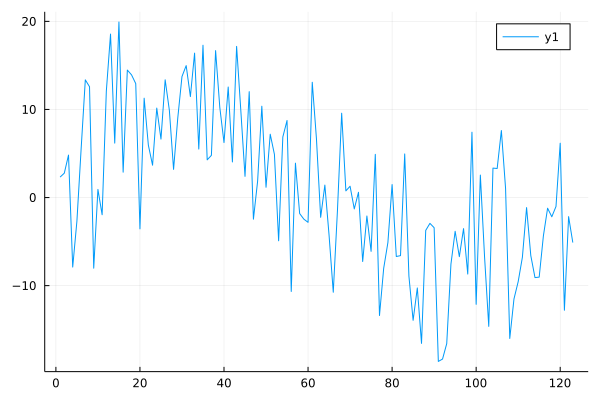

In [17]:
using Plots
# Creating an SPD test problem
m=123;
A=rand(m,m); A=A*A'
x0=sin.(2*pi/m*(1:m));b=A*x0

# SD

plot(b)